# 🛍️ Segmentación de Clientes de E-Commerce

Este proyecto tiene como objetivo identificar distintos grupos de clientes con base en su edad, ingresos y comportamiento de compra, utilizando **clustering (K-Means)** y análisis exploratorio de datos (**EDA**) en Python.

Se busca responder preguntas como:
- ¿Qué tipo de clientes gastan más?
- ¿Qué grupos tienen mayor tasa de abandono?
- ¿Qué estrategias podrían ayudar a retener a los clientes más valiosos?



In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/clientes-ecommerce/ecommerce_customers_dirty.csv")

In [2]:
import warnings
import numpy as np

# Silenciar RuntimeWarnings (por ejemplo: comparaciones con NaN, inf, etc.)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer_ID        500 non-null    object 
 1   Age                490 non-null    float64
 2   Gender             481 non-null    object 
 3   Annual_Income_USD  490 non-null    float64
 4   Spending_Score     500 non-null    int64  
 5   Country            500 non-null    object 
 6   Churned            467 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 27.5+ KB


In [4]:
df.describe()

,Age,Annual_Income_USD,Spending_Score,Churned
count,490.000000,490.000000,500.000000,467.000000
mean,34.693878,51303.365306,47.848000,0.286938
std,11.752743,20089.130465,29.839667,0.452817
min,-3.000000,-7925.000000,-1.000000,0.000000
25%,26.000000,37828.000000,21.000000,0.000000
50%,35.000000,51404.500000,46.500000,0.000000
75%,42.000000,64008.250000,74.000000,1.000000
max,81.000000,101594.000000,100.000000,1.000000


In [5]:
df.head()

,Customer_ID,Age,Gender,Annual_Income_USD,Spending_Score,Country,Churned
0,CUST0000,40.0,Female,46657.0,24,Brazil,1.0
1,CUST0001,33.0,Female,52934.0,99,Brazil,1.0
2,CUST0002,42.0,Male,74130.0,24,Mexico,0.0
3,CUST0003,53.0,NaN,33661.0,17,Canada,1.0
4,CUST0004,NaN,Female,57373.0,5,Canada,0.0


In [6]:
df.isnull().sum()

Customer_ID           0
Age                  10
Gender               19
Annual_Income_USD    10
Spending_Score        0
Country               0
Churned              33
dtype: int64

In [7]:
import numpy as np

def detect_outliers_iqr(df, columna):
    # Reemplazar valores infinitos por NaN
    df[columna] = df[columna].replace([np.inf, -np.inf], np.nan)

    # Calcular IQR ignorando NaN
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    # Comparar solo si el valor no es NaN
    df[f"{columna}_es_outlier"] = df[columna].apply(
        lambda x: x < limite_inferior or x > limite_superior if pd.notnull(x) else False
    )

    print(f"🔍 Outliers detectados en '{columna}': {df[f'{columna}_es_outlier'].sum()}")
    return df

In [8]:
# Detectar outliers en Age

df = detect_outliers_iqr(df, "Age")

🔍 Outliers detectados en 'Age': 4


In [9]:

df[df["Age_es_outlier"] == True]

,Customer_ID,Age,Gender,Annual_Income_USD,Spending_Score,Country,Churned,Age_es_outlier
179,CUST0179,67.0,Male,40124.0,37,Brazil,0.0,True
209,CUST0209,81.0,Male,29201.0,60,Unknown,NaN,True
262,CUST0262,-3.0,Female,69635.0,19,Mexico,0.0,True
478,CUST0478,71.0,Female,79423.0,33,Canada,0.0,True


In [10]:
# Imputar con mediana los valores negativos y nulos

mediana_edad = df['Age'].median()
df.loc[df['Age'] < 0, 'Age'] = mediana_edad

df['Age'] = df['Age'].fillna(mediana_edad)

In [11]:
# Imputar nulos con moda para el genero

moda_genero = df['Gender'].mode()[0]
df['Gender'] = df['Gender'].fillna(moda_genero)

In [12]:
# Detectar outliers en Spending_Score

df = detect_outliers_iqr(df, "Spending_Score")
df[df["Spending_Score_es_outlier"] == True]

🔍 Outliers detectados en 'Spending_Score': 0


,Customer_ID,Age,Gender,Annual_Income_USD,Spending_Score,Country,Churned,Age_es_outlier,Spending_Score_es_outlier


In [13]:
# Imputar con mediana los valores negativos

mediana_ss = df['Age'].median()
df.loc[df['Spending_Score'] < 0, 'Spending_Score'] = mediana_ss

In [14]:
# Detectar outliers en Annual_Income_USD

df = detect_outliers_iqr(df, "Annual_Income_USD")
df[df["Annual_Income_USD_es_outlier"] == True]

🔍 Outliers detectados en 'Annual_Income_USD': 3


,Customer_ID,Age,Gender,Annual_Income_USD,Spending_Score,Country,Churned,Age_es_outlier,Spending_Score_es_outlier,Annual_Income_USD_es_outlier
165,CUST0165,39.0,Male,-6970.0,75,Unknown,0.0,False,False,True
205,CUST0205,23.0,Male,-7925.0,82,Unknown,0.0,False,False,True
459,CUST0459,20.0,Female,-1820.0,72,Brazil,0.0,False,False,True


In [15]:
# Imputar con mediana los valores negativos y nulos

mediana_aiusd = df['Annual_Income_USD'].median()
df.loc[df['Annual_Income_USD'] < 0, 'Annual_Income_USD'] = mediana_aiusd

df['Annual_Income_USD'] = df['Annual_Income_USD'].fillna(mediana_aiusd)

In [16]:
# Imputar con moda los nulos en la columna Churned

moda_churned = df['Churned'].mode()[0]
df['Churned'] = df['Churned'].fillna(moda_churned)

In [17]:
df["Country"].unique()
df["Country"].value_counts()

Country
Canada     113
Brazil     109
USA        104
Unknown    101
Mexico      73
Name: count, dtype: int64

In [18]:
# Eliminar registros de edad atipicos y filtrar
df = df[df["Age"] >= 18]

In [19]:
# Eliminar columnas que ya no se necesitan

df.drop(columns = ["Spending_Score_es_outlier", "Age_es_outlier", "Annual_Income_USD_es_outlier"], inplace = True)

In [20]:
# Gurdar CSV limpio

df.to_csv('/kaggle/working/clientes_ecommerce_limpio.csv', index = False)

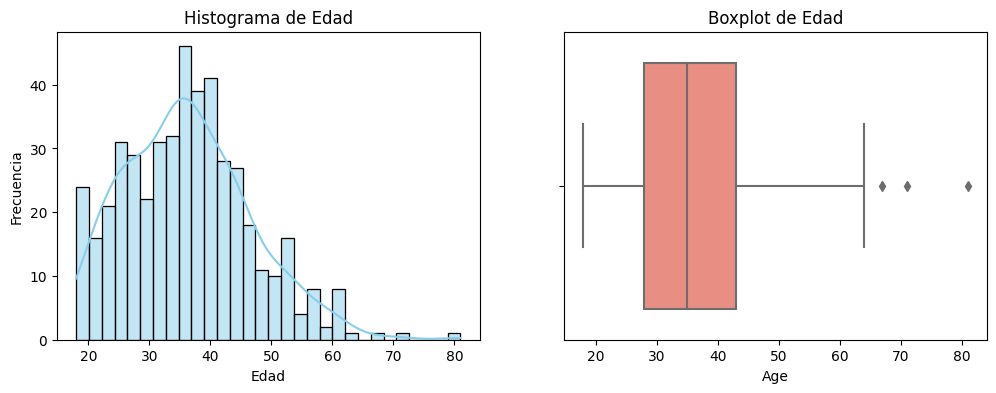

In [21]:
# Histplot y boxplot de Age

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4))

plt.subplot(1, 2, 1)
sns.histplot(df["Age"], bins = 30, kde = True, color = "skyblue" )
plt.title("Histograma de Edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
sns.boxplot(x = df["Age"], color = 'salmon')
plt.title("Boxplot de Edad")

plt.show()

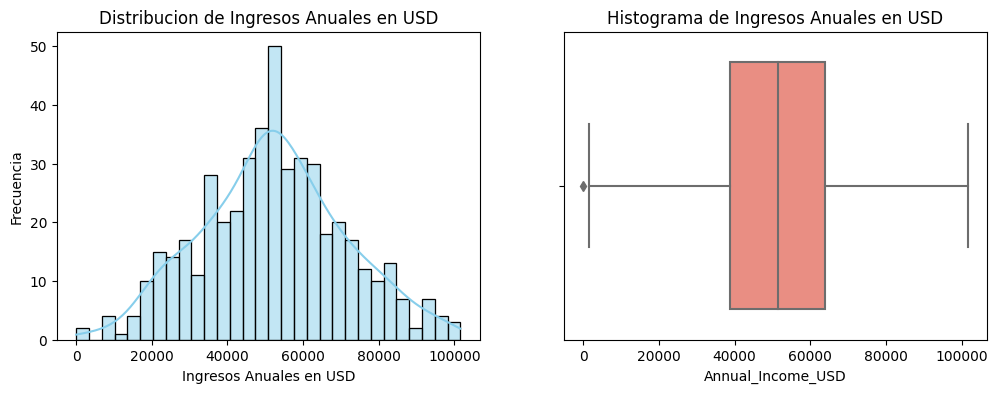

In [22]:
# Histplot y boxplot de Annual_Income_USD

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4))

plt.subplot(1, 2, 1)
sns.histplot(df["Annual_Income_USD"], bins = 30, kde = True, color = "skyblue" )
plt.title("Distribucion de Ingresos Anuales en USD")
plt.xlabel("Ingresos Anuales en USD")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
sns.boxplot(x = df["Annual_Income_USD"], color = 'salmon')
plt.title("Histograma de Ingresos Anuales en USD")

plt.show()

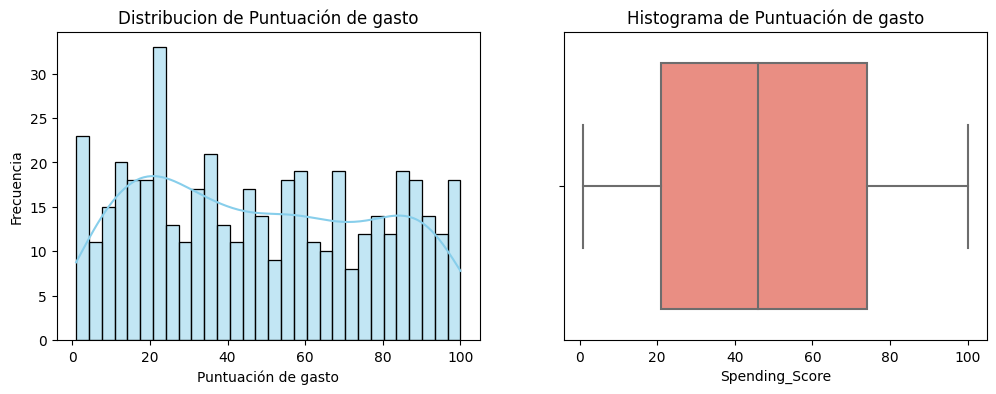

In [23]:
# Histplot y boxplot de Spending_Score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,4))

plt.subplot(1, 2, 1)
sns.histplot(df["Spending_Score"], bins = 30, kde = True, color = "skyblue" )
plt.title("Distribucion de Puntuación de gasto")
plt.xlabel("Puntuación de gasto")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
sns.boxplot(x = df["Spending_Score"], color = 'salmon')
plt.title("Histograma de Puntuación de gasto")

plt.show()

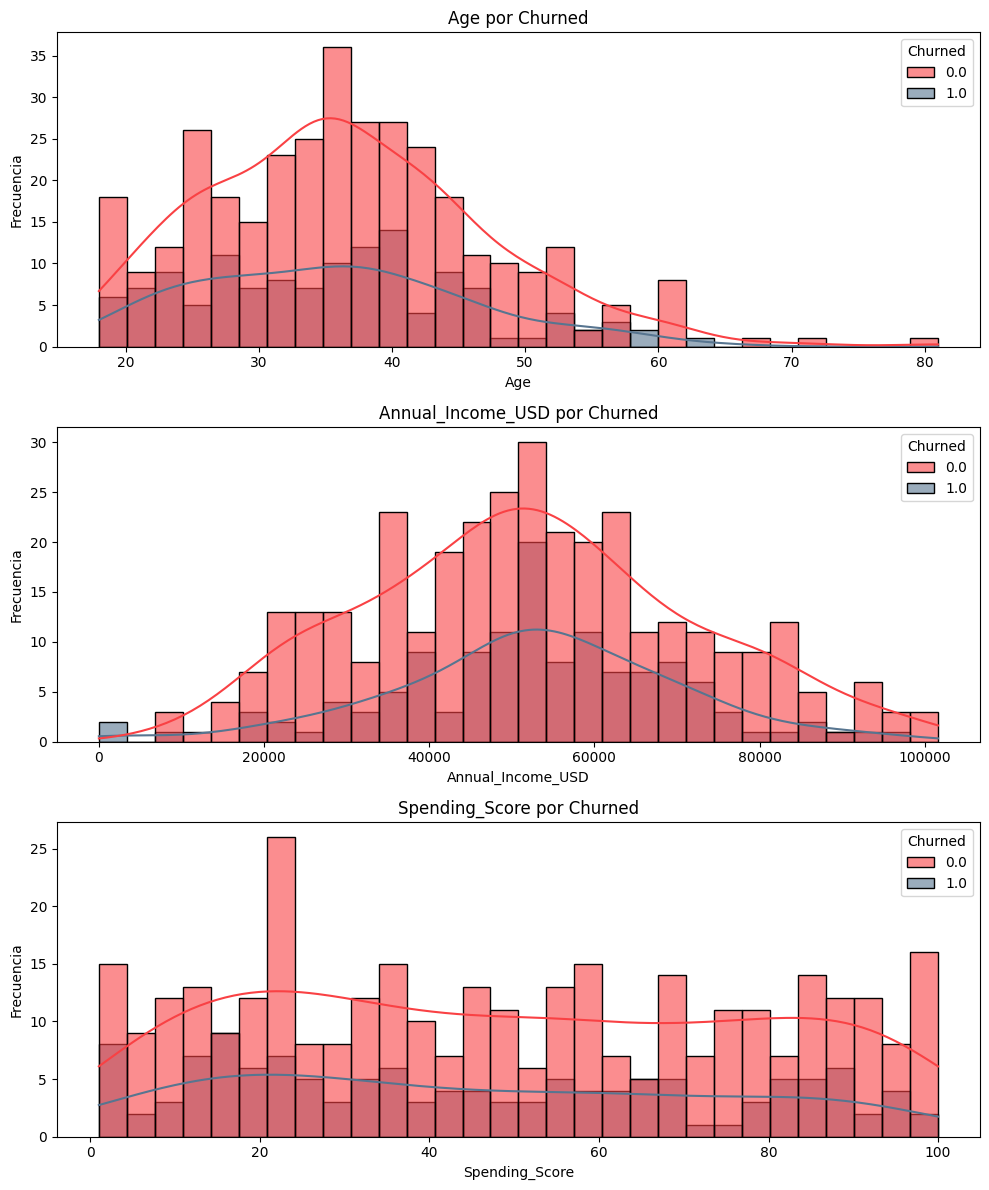

In [24]:
# Distribucion de Edad, Ingreso, Score segun Churned

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axs = plt.subplots(3, 1, figsize = (10,12))

columnas = ["Age", "Annual_Income_USD", "Spending_Score"]
colores = ["#f94144", "#577590"]

for i, col in enumerate(columnas):
    sns.histplot(

        data = df,
        x = col,
        hue = 'Churned',
        kde = True,
        bins = 30,
        alpha = 0.6,
        palette = colores,
        ax = axs[i] )

    axs[i].set_title(f"{col} por Churned")
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Frecuencia")
    
plt.tight_layout()
plt.show()

In [25]:
# Determinar las medias

df.groupby("Churned")[["Age", "Annual_Income_USD", "Spending_Score"]].agg(["mean", "count", "std"])

Age                  Annual_Income_USD                      \
             mean count        std              mean count           std   
Churned                                                                    
0.0      36.52071   338  10.434244      52010.607988   338  19622.415318   
1.0      35.50000   130  10.175400      52577.673077   130  17396.818665   

        Spending_Score                   
                  mean count        std  
Churned                                  
0.0          49.183432   338  29.519527  
1.0          45.053846   130  28.750008

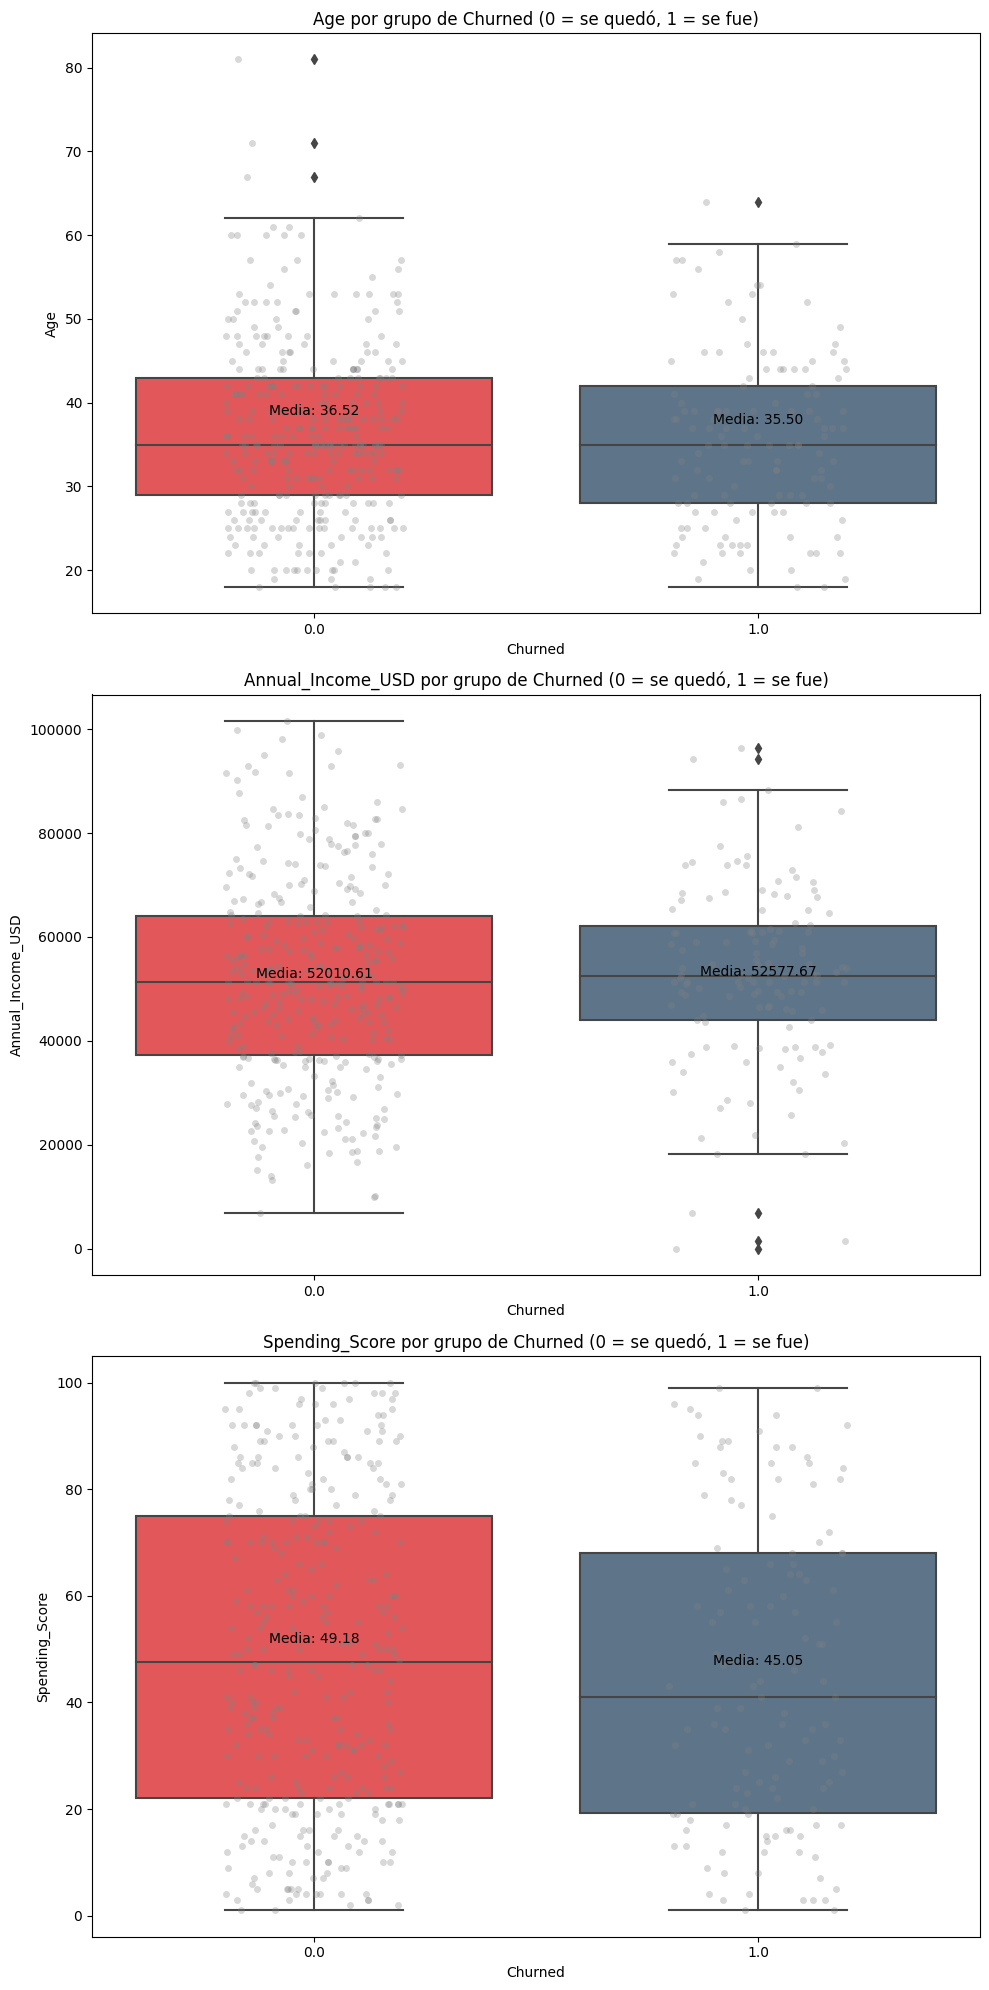

In [26]:
# Boxplot de Edad, Ingreso, Score segun la media

import numpy as np

# Reemplazar valores infinitos antes de graficar
df.replace([np.inf, -np.inf], np.nan, inplace=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axs = plt.subplots(3, 1, figsize=(10, 20))

columnas = ["Age", "Annual_Income_USD", "Spending_Score"]
colores = ["#f94144", "#577590"]

for i, col in enumerate(columnas):
    sns.boxplot(data=df, x="Churned", y=col, palette=colores, ax=axs[i])
    sns.stripplot(data=df, x="Churned", y=col, color='gray', alpha=0.3, jitter=0.2, ax=axs[i])

    media_0 = df[df["Churned"] == 0.0][col].mean()
    media_1 = df[df["Churned"] == 1.0][col].mean()

    axs[i].text(x=0, y=media_0 + 2, s=f"Media: {media_0:.2f}", ha='center', color='black')
    axs[i].text(x=1, y=media_1 + 2, s=f"Media: {media_1:.2f}", ha='center', color='black')

    axs[i].set_title(f"{col} por grupo de Churned (0 = se quedó, 1 = se fue)")
    axs[i].set_xlabel("Churned")
    axs[i].set_ylabel(col)

# Eliminar leyendas si existen
for ax in axs:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

In [27]:
# T -Test (Diferencia entre dos grupos es real o suerte)

from scipy.stats import ttest_ind

grupo_0 = df[df["Churned"] == 0]
grupo_1 = df[df["Churned"] == 1]

resultados = {

    "Age": ttest_ind(grupo_0["Age"], grupo_1["Age"], equal_var=False),
    "Annual_Income_USD": ttest_ind(grupo_0["Annual_Income_USD"], grupo_1["Annual_Income_USD"], equal_var=False),
    "Spending_Score": ttest_ind(grupo_0["Spending_Score"], grupo_1["Spending_Score"],equal_var=False)

}

df_resultados = pd.DataFrame({
    "Variable": resultados.keys(),
    "t-statistic": [r.statistic for r in resultados.values()],
    "p-value": [r.pvalue for r in resultados.values()]
})

print(df_resultados)

            Variable  t-statistic   p-value
0                Age     0.965100  0.335469
1  Annual_Income_USD    -0.304538  0.760960
2     Spending_Score     1.381427  0.168434


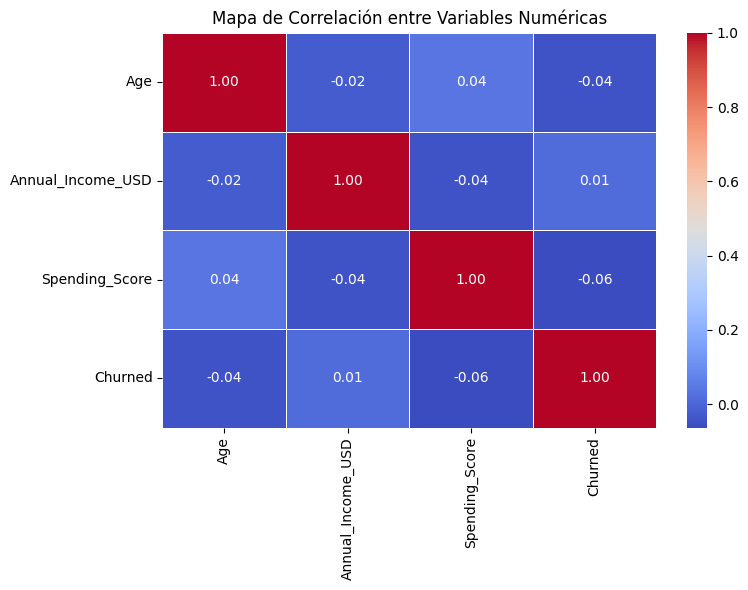

In [28]:
# Heatmap de correlacion

df_num = df[["Age", "Annual_Income_USD", "Spending_Score", "Churned"]]
correlaciones = df_num.corr()

plt.figure(figsize = (8,6))
sns.heatmap(
    correlaciones,
    annot = True, #Mostrar los valores dentro del mapa
    cmap = "coolwarm", #Colores de azul a rojo
    fmt = ".2f", #Formato a dos decimales
    linewidths = 0.5 #Bordes entre casillas
)

plt.title("Mapa de Correlación entre Variables Numéricas")
plt.tight_layout()

plt.show()


    
    

In [29]:
# Clustering

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import os

# Configuración para evitar exceso de hilos en algunos entornos como Kaggle
os.environ["OMP_NUM_THREADS"] = "2"

# Copia de seguridad del DataFrame ya limpio
df_clustering = df.copy()

# Seleccionamos las variables numéricas que usaremos para el clustering
X = df_clustering[["Age", "Annual_Income_USD", "Spending_Score"]]

# Escalamos los datos para que todas las variables tengan la misma importancia
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos el modelo KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Entrenamos el modelo y asignamos los clusters al df_clustering
df_clustering["Cluster"] = kmeans.fit_predict(X_scaled)

# Contamos cuántos clientes hay en cada grupo
conteo_clusters = df_clustering["Cluster"].value_counts().sort_index()
print("Conteo de clientes por cluster:\n", conteo_clusters)

Conteo de clientes por cluster:
 Cluster
0    139
1    159
2    170
Name: count, dtype: int64


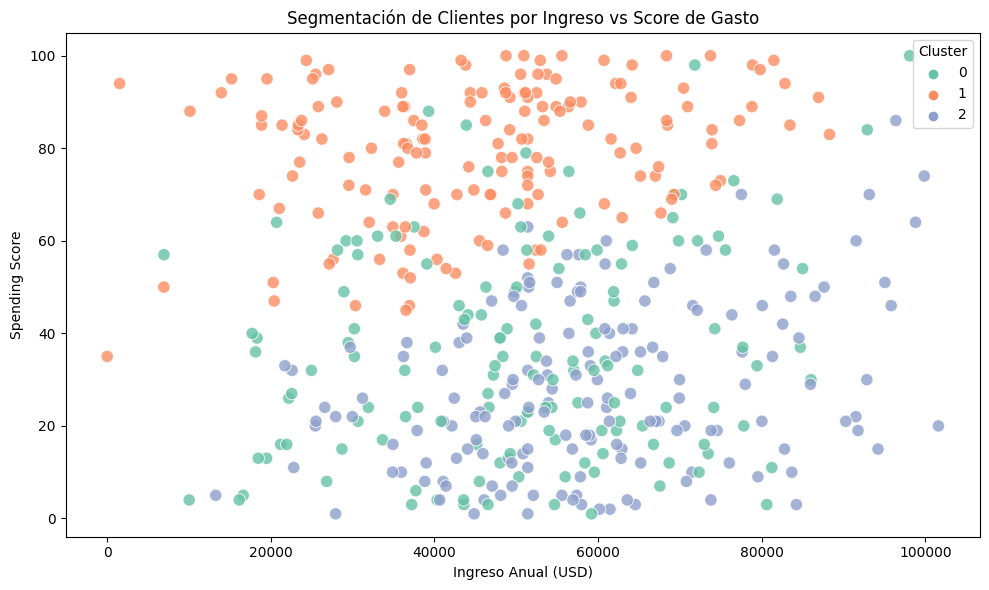

In [30]:
# Gráfico: ingresos vs. score de gasto, coloreado por cluster

# Gráfico: ingresos vs. score de gasto, coloreado por cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clustering,  
    x="Annual_Income_USD",
    y="Spending_Score",
    hue="Cluster",
    palette="Set2",
    s=80,
    alpha=0.8
)

plt.title("Segmentación de Clientes por Ingreso vs Score de Gasto")
plt.xlabel("Ingreso Anual (USD)")
plt.ylabel("Spending Score")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [31]:
#Cruzar clusters con churn
df_clustering.groupby("Cluster")["Churned"].mean()

Cluster
0    0.273381
1    0.251572
2    0.305882
Name: Churned, dtype: float64

In [32]:
#Perfilado por cluster

df_clustering.groupby("Cluster")[["Age", "Annual_Income_USD", "Spending_Score"]].mean()

,Age,Annual_Income_USD,Spending_Score
Cluster,,,
0,47.330935,50672.982014,36.158273
1,34.125786,46034.528302,79.433962
2,29.141176,59127.344118,28.382353


In [33]:
df_clustering.to_csv("/kaggle/working/clientes_segmentados.csv", index=False)

In [34]:
# Perfil Promedio Por Cluster

df_clustering[df_clustering["Cluster"] == 2].groupby("Churned")[["Age", "Annual_Income_USD"]].mean()

,Age,Annual_Income_USD
Churned,,
0.0,29.211864,59310.923729
1.0,28.980769,58710.759615


In [35]:
#cruzamos Cluster con Churned para calcular la tasa de abandono por grupo

df_clustering.groupby("Cluster")["Churned"].mean()


Cluster
0    0.273381
1    0.251572
2    0.305882
Name: Churned, dtype: float64

In [36]:
# Agrupar por cluster y calcular medias
perfil_clusters = df_clustering.groupby("Cluster")[["Age", "Annual_Income_USD", "Spending_Score", "Churned"]].mean().reset_index()

# Renombrar columnas para que sea más entendible
perfil_clusters.columns = [
    "Cluster",
    "Edad_promedio",
    "Ingreso_promedio",
    "Score_promedio",
    "Tasa_de_Churn"
]

# Mostrar resultados
print(perfil_clusters)

   Cluster  Edad_promedio  Ingreso_promedio  Score_promedio  Tasa_de_Churn
0        0      47.330935      50672.982014       36.158273       0.273381
1        1      34.125786      46034.528302       79.433962       0.251572
2        2      29.141176      59127.344118       28.382353       0.305882


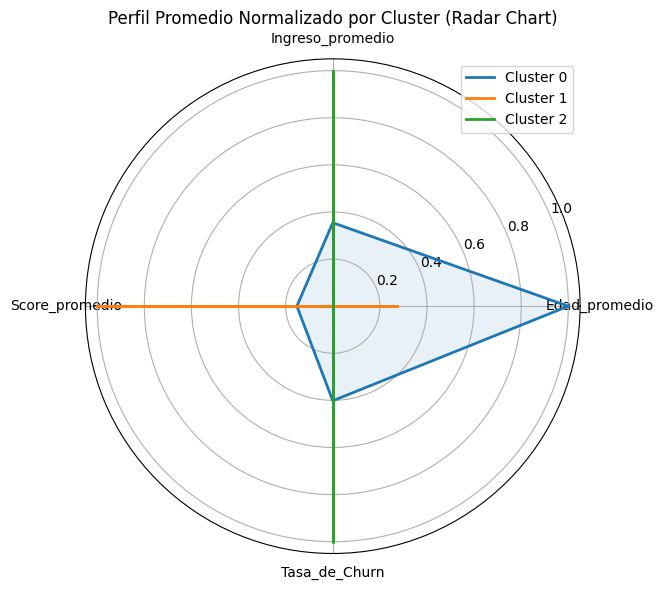

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Normalizar los valores de 0 a 1 por columna (para que todo entre en el radar)
perfil_normalizado = perfil_clusters.copy()
variables = ["Edad_promedio", "Ingreso_promedio", "Score_promedio", "Tasa_de_Churn"]

for col in variables:
    min_val = perfil_clusters[col].min()
    max_val = perfil_clusters[col].max()
    perfil_normalizado[col] = (perfil_clusters[col] - min_val) / (max_val - min_val)

# Preparar datos para radar
labels = variables
num_vars = len(labels)

# Ángulos para cada eje del radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # cerrar el círculo

# Plot
plt.figure(figsize=(8, 6))
for i, row in perfil_normalizado.iterrows():
    valores = row[variables].tolist()
    valores += valores[:1]  # cerrar el gráfico
    plt.polar(angles, valores, label=f"Cluster {int(row['Cluster'])}", linewidth=2)
    plt.fill(angles, valores, alpha=0.1)

plt.xticks(angles[:-1], labels)
plt.title("Perfil Promedio Normalizado por Cluster (Radar Chart)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

<Axes: xlabel='Annual_Income_USD', ylabel='Spending_Score'>

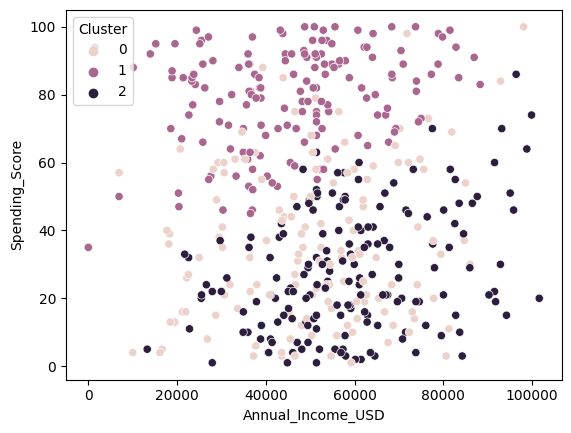

In [38]:
sns.scatterplot(data=df_clustering, x="Annual_Income_USD", y="Spending_Score", hue="Cluster")

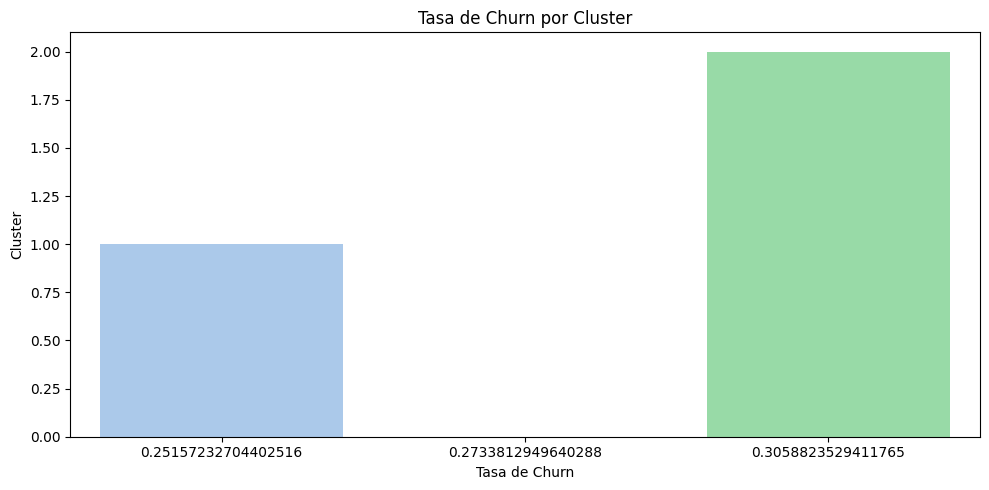

In [39]:
# Calcular tasa de churn por cluster
churn_por_cluster = df_clustering.groupby("Cluster")["Churned"].mean().reset_index()
churn_por_cluster.columns = ["Cluster", "Tasa_de_Churn"]

# Gráfico de barras horizontales
plt.figure(figsize=(10, 5))
sns.barplot(
    data=churn_por_cluster,
    y="Cluster",
    x="Tasa_de_Churn",
    palette="pastel",
    
)
plt.title("Tasa de Churn por Cluster")
plt.xlabel("Tasa de Churn")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [40]:
import plotly.express as px

# Mapa de clientes por pais
# Agrupar por país y contar clientes
clientes_por_pais = df_clustering["Country"].value_counts().reset_index()
clientes_por_pais.columns = ["Country", "Clientes"]

# Crear mapa
fig = px.choropleth(
    clientes_por_pais,
    locations="Country",
    locationmode="country names",  # O usa "ISO-3" si tienes códigos
    color="Clientes",
    color_continuous_scale="Blues",
    title="Distribución de Clientes por País"
)
fig.show()

In [41]:
perfil_clusters = df_clustering.groupby("Cluster")[["Age", "Annual_Income_USD", "Spending_Score", "Churned"]].mean().reset_index()
perfil_clusters.columns = ["Cluster", "Edad_promedio", "Ingreso_promedio", "Score_promedio", "Tasa_de_Churn"]

perfil_clusters.to_csv("/kaggle/working/perfil_clusters.csv", index=False)

## 🧠 Conclusiones

- El **Cluster 1** representa a clientes con ingresos bajos pero alto gasto. Son los más rentables y con menor tasa de abandono.
- El **Cluster 2** tiene ingresos más altos, pero gasta menos y presenta la tasa de abandono más alta. Podría beneficiarse de estrategias de fidelización.
- El **Cluster 0** es neutral en todos los sentidos, con valores intermedios.

Estos insights permiten a las empresas **personalizar sus campañas** y **optimizar la retención de clientes** a partir de datos reales.